In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

In [3]:
original = pywt.data.camera()

#### wavedec2 vs dwt2

In [47]:
c = pywt.wavedec2(original, wavelet='db7', level=2)
len(c)

3

In [46]:
c[0].shape, c[1][0].shape,c[1][1].shape,c[1][2].shape, c[2][0].shape,c[2][1].shape,c[2][2].shape, original.shape

((133, 133),
 (133, 133),
 (133, 133),
 (133, 133),
 (259, 259),
 (259, 259),
 (259, 259),
 (512, 512))

In [19]:
def dwt_(inp_img):
    coeffs2 = pywt.wavedec2(inp_img, 'db2', level=1)
    LL, (LH, HL, HH) = coeffs2
    titles = ['Approximation', ' Horizontal detail',
              'Vertical detail', 'Diagonal detail']
    fig = plt.figure(figsize=(12, 3))
    for i, a in enumerate([LL, LH, HL, HH]):
        ax = fig.add_subplot(1, 4, i + 1)
        ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
        ax.set_title(titles[i], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()
    return LL, LH, HL, HH

(512, 512)


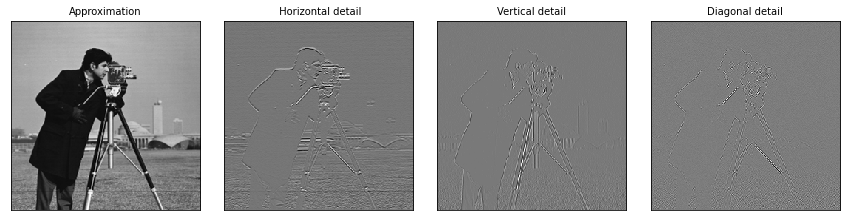

(257, 257)


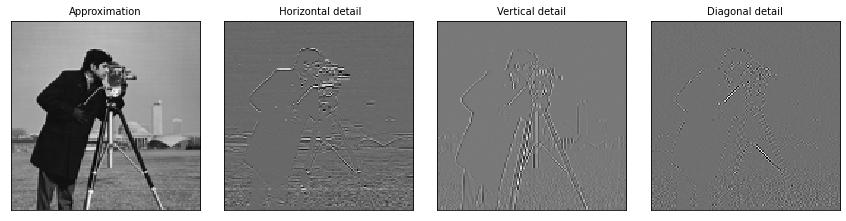

(130, 130)


In [20]:
LL = original
level = 2
print(LL.shape)
for i in range(level):
    LL, LH, HL, HH = dwt_(LL)
    print(LL.shape)

In [ ]:
img_f = pywt.idwt2((LL, (LH, HL, HH)), 'db2')
plt.imshow(img_f)
print(img_f.shape)

In [ ]:
# backpropagation
coeffs2 = pywt.dwt2(original, 'db2')
LL, (LH, HL, HH) = coeffs2
# LL = np.vstack((np.hstack((LL,LH)), np.hstack((HL,HH))))
# print(LL.shape)
img_ = pywt.idwt2(([pywt.idwt2((LL, (LH, HL, HH)), 'db2')][0]  , (cv2.pyrUp(LH)[:512,:512], cv2.pyrUp(HL)[:512,:512], cv2.pyrUp(HH)[:512,:512])), 'db2')
plt.imshow(img_)
img_.shape

Replicating forward and backward passes for wavelet pooling using pywt, ptwt

In [3]:
import ptwt, pywt, torch
import numpy as np
import scipy.misc
import torch.nn as nn

In [5]:
# face = np.transpose(scipy.misc.face(),
#                         [2, 0, 1]).astype(np.float64)
input_ = torch.ones(3,16,16) #torch.tensor(face)
# input_ = input_[:,:-1,:-1]
input_ = torch.unsqueeze(torch.tensor(input_),  dim = 0).repeat(4,1,1,1)
INPUT_SIZE_ = input_.size()
INPUT_SIZE_CAHCED_ = INPUT_SIZE_
print(INPUT_SIZE_)

## -- forward -------------------------------------
print('Forward funtion of wavelet pooling --')
print('Input dim - ' + str(input_.shape))

bs = INPUT_SIZE_[0]
FORWARD_OUTPUT_ = []
# loop over input as batching not supported
for k in range(bs):
    coefficients = ptwt.wavedec2(torch.squeeze(input_[k,:,:,:]), pywt.Wavelet("haar"),
                                level=2, mode="constant")
    
    # 2nd order DWT
    forward_output_ = ptwt.waverec2([coefficients[0], coefficients[1]], pywt.Wavelet("haar"))
    FORWARD_OUTPUT_.append(torch.squeeze(forward_output_, dim = 1))

FORWARD_OUTPUT_ = torch.stack(FORWARD_OUTPUT_)
# print(FORWARD_OUTPUT_)
# print("")
# print("Output dim - " + str(FORWARD_OUTPUT_.size()))
# print("----------------")


# backward_input_ = FORWARD_OUTPUT_
# ## -- backward -------------------------------------
# INPUT_SIZE_ = backward_input_.size()
# print("Input to backward - " + str(INPUT_SIZE_))
# bs = INPUT_SIZE_[0]
# BACKWARD_OUTPUT_ = []
# upsample_ = nn.Upsample(scale_factor=2, mode='nearest')

# # loop over input as batching not supported
# for k in range(bs):
#     # 1st order DWT
#     coefficients = ptwt.wavedec2(torch.squeeze(backward_input_[k,:,:,:]), pywt.Wavelet("haar"),
#                                     level=1, mode="constant")
#     # upsample subbands
#     upsampled_subbands_ = []
#     upsampled_subbands_.append(torch.cat(( torch.cat((coefficients[0], coefficients[1][0]), dim = 3) , torch.cat((coefficients[1][1], coefficients[1][2]), dim = 3)), dim = 2))
#     upsampled_subbands_.append([])
#     for k in range(len(coefficients[1])):
#         upsampled_subbands_[-1].append(upsample_(coefficients[1][k]))
#     upsampled_subbands_[-1] = tuple(upsampled_subbands_[-1])  
    
#     # IDWT
#     backward_output_ = ptwt.waverec2(upsampled_subbands_, pywt.Wavelet("haar"))
#     BACKWARD_OUTPUT_.append(backward_output_.squeeze())

# BACKWARD_OUTPUT_ = torch.stack(BACKWARD_OUTPUT_)
# BACKWARD_OUTPUT_SHAPE_ = BACKWARD_OUTPUT_.shape

# if INPUT_SIZE_CAHCED_ != BACKWARD_OUTPUT_SHAPE_:
#     # Ensure output dim matches input dim
#     if INPUT_SIZE_CAHCED_[2] != BACKWARD_OUTPUT_SHAPE_[2]:
#         BACKWARD_OUTPUT_ = BACKWARD_OUTPUT_[:,:,:-1,:]
#     if INPUT_SIZE_CAHCED_[3] != BACKWARD_OUTPUT_SHAPE_[3]:
#         BACKWARD_OUTPUT_ = BACKWARD_OUTPUT_[:,:,:,:-1]
     

# print("Output of backward - " + str(BACKWARD_OUTPUT_.shape))

torch.Size([4, 3, 16, 16])
Forward funtion of wavelet pooling --
Input dim - torch.Size([4, 3, 16, 16])


In [ ]:
coefficients[0], coefficients[1][0], coefficients[1][1], coefficients[1][2]

Wavelet pooling layer as a torch autograd function

In [ ]:
import torch
import numpy as np
import scipy.misc
import ptwt, pywt
import torch.nn as nn
import torch.optim as optim

In [ ]:
class WaveletPooling_(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, wavelet = "haar"):
        '''
        Dowsamples by a factor of 2 by applying IDWT on the 
        second level subband of the DWT output.
        '''
        print('WAVELET POOLING FORWARD....')
        INPUT_SIZE_ = x.size()
        ctx.save_for_backward(torch.tensor(INPUT_SIZE_))
        ctx.wavelet = wavelet
        
        bs = INPUT_SIZE_[0]
        FORWARD_OUTPUT_ = []
        
        # loop over input as batching not supported
        for k in range(bs):
            coefficients = ptwt.wavedec2(torch.squeeze(x[k,:,:,:]), pywt.Wavelet(wavelet),
                                        level=2, mode="constant")

            # 2nd order DWT
            forward_output_ = ptwt.waverec2([coefficients[0], coefficients[1]], pywt.Wavelet(wavelet))
            FORWARD_OUTPUT_.append(torch.squeeze(forward_output_, dim = 1))

        FORWARD_OUTPUT_ = torch.stack(FORWARD_OUTPUT_)
        
        return FORWARD_OUTPUT_
    
    @staticmethod
    def backward(ctx, x):
        '''
        Applies IDWT on upsampled 1st level DWT of the 
        input.
        '''
        print('WAVELET POOLING BACKWARD....')
        INPUT_CAHCED_, = ctx.saved_tensors
        print(ctx.wavelet)
                            
        bs = x.size()[0]

        BACKWARD_OUTPUT_ = []
        upsample_ = nn.Upsample(scale_factor=2, mode='nearest')

        # loop over input as batching not supported
        for k in range(bs):
            # 1st order DWT
            coefficients = ptwt.wavedec2(torch.squeeze(x[k,:,:,:]), pywt.Wavelet("haar"),
                                            level=1, mode="constant")
            # upsample subbands
            upsampled_subbands_ = []
            upsampled_subbands_.append(torch.cat(( torch.cat((coefficients[0], coefficients[1][0]), dim = 3) , \
                                       torch.cat((coefficients[1][1], coefficients[1][2]), dim = 3)), dim = 2))
            upsampled_subbands_.append([])
            for k in range(len(coefficients[1])):
                upsampled_subbands_[-1].append(upsample_(coefficients[1][k]))
            upsampled_subbands_[-1] = tuple(upsampled_subbands_[-1])  

            # IDWT
            backward_output_ = ptwt.waverec2(upsampled_subbands_, pywt.Wavelet("haar"))
            BACKWARD_OUTPUT_.append(backward_output_.squeeze())

        BACKWARD_OUTPUT_ = torch.stack(BACKWARD_OUTPUT_)
        BACKWARD_OUTPUT_SHAPE_ = BACKWARD_OUTPUT_.shape
        INPUT_SIZE_CAHCED_, = ctx.saved_tensors
        INPUT_SIZE_CAHCED_ = tuple(INPUT_SIZE_CAHCED_.tolist())

        # Ensure output dim matches input dim
        if INPUT_SIZE_CAHCED_ != BACKWARD_OUTPUT_SHAPE_:
            if INPUT_SIZE_CAHCED_[2] != BACKWARD_OUTPUT_SHAPE_[2]:
                BACKWARD_OUTPUT_ = BACKWARD_OUTPUT_[:,:,:-1,:]
            if INPUT_SIZE_CAHCED_[3] != BACKWARD_OUTPUT_SHAPE_[3]:
                BACKWARD_OUTPUT_ = BACKWARD_OUTPUT_[:,:,:,:-1]
        
        return BACKWARD_OUTPUT_, None

In [ ]:
# # Testing wavelet pooling autograd function
# face = np.transpose(scipy.misc.face(),
#                         [2, 0, 1]).astype(np.float64)
# input_ = torch.unsqueeze(torch.tensor(face),  dim = 0).repeat(4,1,1,1)
# input_.requires_grad = True
# criterion = nn.MSELoss()

# y = WaveletPooling_.apply(input_)
# target_ = torch.zeros_like(y)
# loss = criterion(output_, target_)
# loss.requires_grad = True
# loss.backward()

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3,3,1,1)
        self.pool = WaveletPooling_.apply
        self.conv2 = nn.Conv2d(3,1,1,1)
        
    def forward(self, x):
        '''
        Dowsamples by a factor of 2 by applying IDWT on the 
        second level subband of the DWT output.
        '''
        y = self.conv1(x)
        y = self.pool(x)
#         y = self.conv2(x)
        return y

In [ ]:
face = np.transpose(scipy.misc.face(),
                        [2, 0, 1]).astype(np.float64)
input_ = torch.unsqueeze(torch.tensor(face),  dim = 0).repeat(4,1,1,1)

criterion = nn.MSELoss()
m = Model()

optimizer = optim.SGD(m.parameters(), lr=1e-3)
optimizer.zero_grad()

output_ = m(input_.float())
target_ = torch.zeros_like(output_)
print(output_.shape, target_.shape)

loss = criterion(output_, target_)
print(loss.requires_grad)
loss.backward()
optimizer.step()

In [ ]:
import torch
import numpy as np
import scipy.misc
import ptwt, pywt
import torch.nn as nn
import torch.optim as optim

In [ ]:
class WaveletPooling(nn.Module):
    def __init__(self, wavelet = "haar"):
        super(WaveletPooling, self).__init__()
        self.wavelet = wavelet
    
    def forward(self, x):
        '''
        Dowsamples by a factor of 2 by applying IDWT on the 
        second level subband of the DWT output.
        '''
        bs = x.size()[0]
        FORWARD_OUTPUT_ = []
        
        # loop over input as batching not supported
        for k in range(bs):
            coefficients = ptwt.wavedec2(torch.squeeze(x[k,:,:,:]), pywt.Wavelet(self.wavelet),
                                        level=2, mode="constant")

            # 2nd order DWT
            forward_output_ = ptwt.waverec2([coefficients[0], coefficients[1]], pywt.Wavelet(self.wavelet))
            FORWARD_OUTPUT_.append(torch.squeeze(forward_output_, dim = 1))

        FORWARD_OUTPUT_ = torch.stack(FORWARD_OUTPUT_)
        print('Forward ...')
        print(x.size(), FORWARD_OUTPUT_.size())
        return FORWARD_OUTPUT_

In [ ]:
def gradient_hook(self, input_, output_):
    print('Hook...')
    print(input_[0].shape, output_[0].shape)
    upsample_ = nn.Upsample(scale_factor=2, mode='nearest')
    gradient = []
    # loop over input as batching not supported
    for k in range(len(input_)):
        # 1st order DWT
        coefficients = ptwt.wavedec2(input_[k], pywt.Wavelet(self.wavelet),
                                        level=1, mode="constant")
        # upsample subbands
        upsampled_subbands_ = []
        upsampled_subbands_.append(torch.cat(( torch.cat((coefficients[0], coefficients[1][0]), dim = 3) , \
                                   torch.cat((coefficients[1][1], coefficients[1][2]), dim = 3)), dim = 2))
        upsampled_subbands_.append([])
        for k in range(len(coefficients[1])):
            upsampled_subbands_[-1].append(upsample_(coefficients[1][k]))
        upsampled_subbands_[-1] = tuple(upsampled_subbands_[-1])  

        # IDWT
        backward_output_ = ptwt.waverec2(upsampled_subbands_, pywt.Wavelet(self.wavelet))
        gradient.append(backward_output_.squeeze())
    input_ = tuple(gradient)
    print(input_[0].shape)

In [ ]:
face = np.transpose(scipy.misc.face(),
                        [2, 0, 1]).astype(np.float64)
input_ = torch.unsqueeze(torch.tensor(face),  dim = 0).repeat(4,1,1,1)
input_.requires_grad = True

layer = WaveletPooling()
layer.register_backward_hook(gradient_hook)
optimizer = optim.SGD(layer.parameters(), lr=1e-3)

# forward
layer.train()
# a = torch.full((), 0.0, dtype=torch.float, requires_grad=True)
output_ = layer(input_) #+ a

loss = (output_ - torch.zeros_like(output_)).pow(2).sum()

optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
class Pooling(nn.Module):
    def __init__(self):
        super(Pooling, self).__init__()
        self.pool = nn.MaxPool2d(3, stride=2)
        
    def forward(self, x):
        '''
        Dowsamples by a factor of 2 by applying IDWT on the 
        second level subband of the DWT output.
        '''
        return self.pool(x)

In [ ]:
def gradient_hook(self, input_, output_):
    print(input_[0].shape, output_[0].shape)
#     upsample_ = nn.Upsample(scale_factor=2, mode='nearest')
#     gradient = []
#     # loop over input as batching not supported
#     for k in range(len(input_)):
#         # 1st order DWT
#         coefficients = ptwt.wavedec2(input_[k], pywt.Wavelet(self.wavelet),
#                                         level=1, mode="constant")
#         # upsample subbands
#         upsampled_subbands_ = []
#         upsampled_subbands_.append(torch.cat(( torch.cat((coefficients[0], coefficients[1][0]), dim = 3) , \
#                                    torch.cat((coefficients[1][1], coefficients[1][2]), dim = 3)), dim = 2))
#         upsampled_subbands_.append([])
#         for k in range(len(coefficients[1])):
#             upsampled_subbands_[-1].append(upsample_(coefficients[1][k]))
#         upsampled_subbands_[-1] = tuple(upsampled_subbands_[-1])  

#         # IDWT
#         backward_output_ = ptwt.waverec2(upsampled_subbands_, pywt.Wavelet(self.wavelet))
#         gradient.append(backward_output_.squeeze())
#     input_ = tuple(gradient)
#     print(input_[0].shape)

In [ ]:
face = np.transpose(scipy.misc.face(),
                        [2, 0, 1]).astype(np.float64)
input_ = torch.unsqueeze(torch.tensor(face),  dim = 0).repeat(4,1,1,1)
input_.requires_grad = True

layer = Pooling()
layer.register_full_backward_hook(gradient_hook)

# forward
layer.train()
# a = torch.full((), 0.0, dtype=torch.float, requires_grad=True)
output_ = layer(input_) #+ a
print(input_.size(), output_.size())

loss = (output_ - torch.zeros_like(output_)).pow(2).sum()
loss.backward()